In [28]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
import keras.preprocessing.image as kimg
from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [29]:
#https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
mat = scipy.io.loadmat('./data/wiki_crop/wiki.mat')

In [30]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [31]:
instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [32]:
len(df)

62328

In [33]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [34]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


In [35]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
    return exact_date.year

In [36]:
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [37]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971


In [38]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [39]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

In [40]:
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [41]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [42]:
len(df)

22578

In [27]:
df.head()

,dob,photo_taken,full_path,gender,age,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,"[tensor(255.), tensor(255.), tensor(255.), ten..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,"[tensor(92.), tensor(97.), tensor(91.), tensor..."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,"[tensor(61.), tensor(30.), tensor(10.), tensor..."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,"[tensor(97.), tensor(122.), tensor(178.), tens..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,"[tensor(190.), tensor(189.), tensor(194.), ten..."


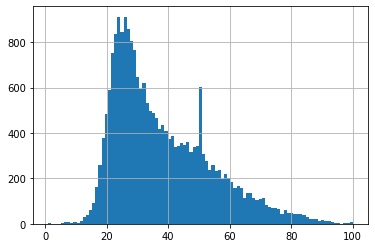

In [15]:
histogram = df['age'].hist(bins=df['age'].nunique())

In [16]:
#df['age'].value_counts().sort_index()

In [17]:
classes = 101 #(0, 100])
print("number of output classes: ",classes)

number of output classes:  101


In [18]:
target_size = (224, 224)

def getImagePixels(image_path):
    try:
        img = image.load_img("./data/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
        x = image.img_to_array(img).reshape(1, -1)[0]
        
        return torch.Tensor(x)
        #x = preprocess_input(x)
    except:
        print("Data not found for the image "+image_path)
    
    return x

In [19]:
df['pixels'] = df['full_path'].apply(getImagePixels)

In [20]:
torch.save(df.pixels.to_list(),"images_torch.pt")
pd.DataFrame.from_dict(df).to_csv("age_gender_data.csv")

In [ ]:
path= df['full_path'].iloc[0]
img_size=(224,224)
img = kimg.load_img("./data/wiki_crop/%s" % path[0], grayscale=False, target_size=img_size)
image = kimg.img_to_array(img).reshape(224, 224, 3)

features=torch.Tensor(image).unsqueeze(0)

for i in tqdm(range(1,df.shape[0])):
    path= df['full_path'].iloc[i]
    img = kimg.load_img("./data/wiki_crop/%s" % path[0], grayscale=False, target_size=img_size)
    image = kimg.img_to_array(img).reshape(224, 224, 3)

    image_tensor=torch.Tensor(image).unsqueeze(0)

    features=torch.cat((features,image_tensor), axis =0)
    
features=features.to(pytorch_device)

In [ ]:
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

In [ ]:
#features = df['pixels'].values
features = []

for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [ ]:
features.shape

In [ ]:
features /= 255 #normalize in [0, 1]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes
                                        , test_size=0.30)#, random_state=42), stratify=target_classes)

In [ ]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('vgg_face_weights.h5')

In [ ]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [ ]:
scores = []

In [ ]:
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model.hdf5")
    
    age_model.save_weights('age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("age_model_weights.h5")

In [ ]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

# Model evaluation on test set

In [ ]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

In [ ]:
predictions = age_model.predict(test_x)

In [ ]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [ ]:
mae = 0

for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
    actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

# Testing model on a custom image

Feed an image to find the apparent age

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [ ]:
picture = "pacino.jpg"
#picture = "brando.jpg"
#picture = "katy-3.jpg"

prediction = age_model.predict(loadImage(picture))

In [ ]:
y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

In [ ]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))

apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))